# Implicit Feedback For Recommendations

In [27]:
from pathlib import Path
from matplotlib import image


In [29]:
IMAGE_DIR = '/Users/grantbeasley/Downloads/images/'
images = Path(IMAGE_DIR)

Quick test of for loop vs list comprehension - no real difference in speed!

In [30]:
all_files = [image for folder in images.iterdir() if not folder.name == '.DS_Store' for image in folder.iterdir() if image.suffix == '.jpg']

### ALS Recommendations



In [4]:
from neo4j import GraphDatabase
import pandas as pd
import datetime as dt

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

We can start by returning all the users, their purchases and dates of the purchase.

For future reference, we should note that the max transaction date in the database is '22-09-2020'

Should create recs on er age group basis as well - although this would likely show up in collaborative filtering approach anyway

In [26]:
with driver.session(database='neo4j') as session:
    
    query = """
    MATCH (c:Customer)-[pur:PURCHASED]->(p:Product)
    RETURN
      c.id as customer_id, p.code as product_code, p.name as product_name, pur.t_date as transaction_date
    """
    
    results = session.run(query)
    
    purchases = [(record['customer_id'], record['product_code'], record['product_name'], record['transaction_date']) for record in results]
    

KeyboardInterrupt: 

In [1]:
import pandas as pd
purchases = pd.read_csv('/Users/grantbeasley/Library/Application Support/Neo4j Desktop/Application/relate-data/dbmss/dbms-8e47f9b7-a408-4d53-915d-8e56e440f5d0/import/transactions_train.csv')

In [2]:
purchases.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

In [3]:
purchases['t_dat'] = pd.to_datetime(purchases['t_dat'])

Using code from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/

In [4]:
n_users = purchases['customer_id'].unique().shape[0]
n_items = purchases['article_id'].unique().shape[0]

print('Number of users: {}'.format(n_users))
print('Number of models: {}'.format(n_items))
print('Sparsity: {:4.3f}%'.format(float(purchases.shape[0]) / float(n_users*n_items) * 100))

Number of users: 1362281
Number of models: 104547
Sparsity: 0.022%


> While implicit recommendations excel where data is sparse, it can often be helpful to make the interactions matrix a little more dense. We limited our data collection to models that had at least 5 likes. However, it may not be the case that every user has liked at least 5 models. Let’s go ahead and knock out users that liked fewer than 5 models. This could possibly mean that some models end up with fewer than 5 likes once these users are knocked out, so we will have to alternate back and forth knocking users and models out until things stabilize.



In [5]:
def threshold_likes(df, user_min, article_min):
    n_users = df['customer_id'].unique().shape[0]
    n_items = df['article_id'].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Starting likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done = False
    while not done:
        starting_shape = df.shape[0]
        article_counts = df.groupby('customer_id')['article_id'].count()
        df = df[~df['customer_id'].isin(article_counts[article_counts < article_min].index.tolist())]
        user_counts = df.groupby('article_id')['customer_id'].count()
        df = df[~df['article_id'].isin(user_counts[user_counts < user_min].index.tolist())]
        ending_shape = df.shape[0]
        if starting_shape == ending_shape:
            done = True
    
    assert(df.groupby('customer_id')['article_id'].count().min() >= article_min)
    assert(df.groupby('article_id')['customer_id'].count().min() >= user_min)
    
    n_users = df['customer_id'].unique().shape[0]
    n_items = df['article_id'].unique().shape[0]
    sparsity = float(df.shape[0]) / float(n_users*n_items) * 100
    print('Ending likes info')
    print('Number of users: {}'.format(n_users))
    print('Number of models: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

In [6]:
purchases_dense = threshold_likes(purchases, 5, 5)

Starting likes info
Number of users: 1362281
Number of models: 104547
Sparsity: 0.022%
Ending likes info
Number of users: 925154
Number of models: 91511
Sparsity: 0.036%


In [7]:
# Create mappings
article_to_idx = {}
idx_to_article = {}
for (idx, aid) in enumerate(purchases_dense['article_id'].unique().tolist()):
    article_to_idx[aid] = idx
    idx_to_article[idx] = aid
    
user_to_idx = {}
idx_to_user = {}
for (idx, uid) in enumerate(purchases_dense['customer_id'].unique().tolist()):
    user_to_idx[uid] = idx
    idx_to_user[idx] = uid

In [8]:
def map_ids(row, mapper):
    return mapper[row]

In [9]:
from scipy import sparse
import numpy as np

I = purchases_dense['customer_id'].apply(map_ids, args=[user_to_idx]).values
J = purchases_dense['article_id'].apply(map_ids, args=[article_to_idx]).values
V = np.ones(I.shape[0])
purchases_sparse = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
purchases_sparse = purchases_sparse.tocsr()

The data above provides no confidence values other than a 1 for each instance of a purchase. We could also look at varying this confidence depending on the recency of the purchases and potentially on the time of year the purchases were made. Given we're predicting items for the week after '2020-09-22' we could also add extra confidence to values around this 3 month period i.e. previous years but in the months of July, August and September

In [10]:
purchases_dense.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [11]:
import datetime as dt

def assign_confidence(date):
    if date >= dt.date(2020,6,20):
        return 5
    elif date.month in (7,8,9):
        return 3
    else:
        return 1

purchases_dense['confidence'] = purchases_dense['t_dat'].apply(assign_confidence)

In [12]:
confidence = purchases_dense['confidence'].values 
purchases_with_confidence = sparse.coo_matrix((confidence, (I, J)), dtype=np.float64)
purchases_with_confidence = purchases_with_confidence.tocsr()

In [13]:
def assign_confidence_recent(date):
    if date >= dt.date(2020,3,20):
        return 5
    elif (date >= dt.date(2020,3,20)) & (date < dt.date(2020,3,20)): 
        return 3
    else:
        return 1
    
purchases_dense['confidence_recent'] = purchases_dense['t_dat'].apply(assign_confidence)

In [14]:
confidence_recent = purchases_dense['confidence_recent'].values 
purchases_with_confidence_recent = sparse.coo_matrix((confidence_recent, (I, J)), dtype=np.float64)
purchases_with_confidence_recent = purchases_with_confidence_recent.tocsr()

## Spliting off a training and testing set

We need to find users who when we take a 5 purchases away, we're still left with at least 5 entries in the training dataset so we need to find users with at least 10 purchases

In [15]:
train = purchases_sparse.copy().tocoo()
test = sparse.lil_matrix(train.shape)

In [16]:
train.row.shape

(26341986,)

In [268]:
fraction = 0.2

user_index = np.random.choice(
    np.nonzero(np.bincount(train.row) >= 10)[0], # the [0] just removes an unused axis
    replace=False,
    size=np.int32(np.floor(fraction * train.shape[0]))
)

train = train.tolil()

In [269]:
split_count = 5

for user in user_index:
    test_ratings = np.random.choice(purchases_sparse.getrow(user).indices, 
                                    size=split_count, 
                                    replace=False)
    train[user, test_ratings] = 0.
    # These are just 1.0 right now
    test[user, test_ratings] = purchases_sparse[user, test_ratings]

In [17]:
# Stolen directly from https://www.ethanrosenthal.com/2016/10/19/implicit-mf-part-1/

def train_test_split(ratings, split_count, fraction=None):
    """
    Split recommendation data into train and test sets
    
    Params
    ------
    ratings : scipy.sparse matrix
        Interactions between users and items.
    split_count : int
        Number of user-item-interactions per user to move
        from training to test set.
    fractions : float
        Fraction of users to split off some of their
        interactions into test set. If None, then all 
        users are considered.
    """
    # Note: likely not the fastest way to do things below.
    train = ratings.copy().tocoo()
    test = sparse.lil_matrix(train.shape)
    
    if fraction:
        try:
            user_index = np.random.choice(
                np.where(np.bincount(train.row) >= split_count * 2)[0],  # the [0] just removes an unused axis
                replace=False,
                size=np.int32(np.floor(fraction * train.shape[0]))
            ).tolist()
        except:
            print(('Not enough users with > {} '
                  'interactions for fraction of {}')\
                  .format(2*k, fraction))
            raise
    else:
        user_index = range(train.shape[0])
        
    train = train.tolil()

    for user in user_index:
        test_ratings = np.random.choice(ratings.getrow(user).indices, 
                                        size=split_count, 
                                        replace=False)
        train[user, test_ratings] = 0.
        # These are just 1.0 right now
        test[user, test_ratings] = ratings[user, test_ratings]
   
    
    # Test and training are truly disjoint
    assert(train.multiply(test).nnz == 0)
    return train.tocsr(), test.tocsr(), user_index

In [18]:
train, test, user_index = train_test_split(purchases_sparse, 5, 0.1)

TO DO:
* Create confidence scores based on date of purchases
* Create training/testing split
* create performance metric
* create plotting function

In [19]:
import implicit
als = implicit.als.AlternatingLeastSquares()

/Users/grantbeasley/anaconda3/envs/py36/lib/python3.6/site-packages/implicit/utils.py:32: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  "Intel MKL BLAS detected. Its highly recommend to set the environment "


In [20]:
als.fit(train)

  0%|          | 0/15 [00:00<?, ?it/s]

In [49]:
rec_ids, rec_scores = als.recommend(169, purchases_sparse[169])

In [50]:
rec_ids

array([ 38553,  21739,   8063,  31511,   8172,  18003,  19437,  59646,
       244972, 109093], dtype=int32)

In [33]:
user_1 = idx_to_user[168]

In [34]:
user_1_purchases = purchases_dense[purchases_dense['customer_id'] == user_1]['article_id'].values

In [41]:
rec_ids, rec_scores

(array([109093,  32841,  34770,  22484,   8172, 171148,  19437,  17727,
           200,    902], dtype=int32),
 array([0.01276562, 0.01003056, 0.01000576, 0.00970861, 0.00969235,
        0.00863682, 0.00863589, 0.00856365, 0.008562  , 0.0084079 ],
       dtype=float32))

In [24]:
def compare_purchases_and_recs(user, recs, rec_scores, idx_to_user, idx_to_article, purchases_df, image_files):
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    user_id = idx_to_user[user]
    print(f"Num purchases for user = {purchases_df[purchases_df['customer_id'] == user_id].shape[0]}")
    user_purchases = purchases_df[purchases_df['customer_id'] == user_id]['article_id'].sample(10).values

    for item, ax in zip(user_purchases[:10], axes.flatten()):
        file = [file for file in image_files if str(item) in file.name]
        if len(file) == 0:
            continue
        img = image.imread(file[0])
        ax.imshow(img)
    fig.show()
    plt.pause(5)
    
    
    fig2, axes2 = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
  
    for item, item_score, ax in zip(recs, rec_scores, axes2.flatten()):
        rec_id = idx_to_article[item]
        file = [file for file in image_files if str(item) in file.name]
        if len(file) == 0:
            ax.set_title(item_score)
            continue
        img = image.imread(file[0])
        ax.imshow(img)
        ax.set_title(item_score)
    
    fig2.show()
    plt.pause(5)
    
    

Num purchases for user = 47


/Users/grantbeasley/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


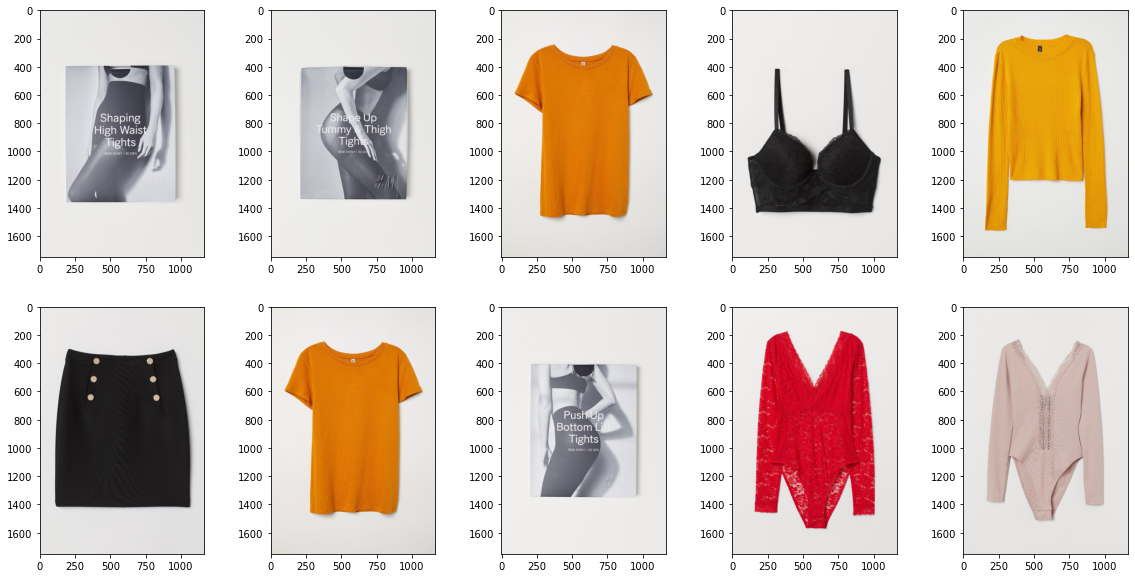

KeyError: 109093

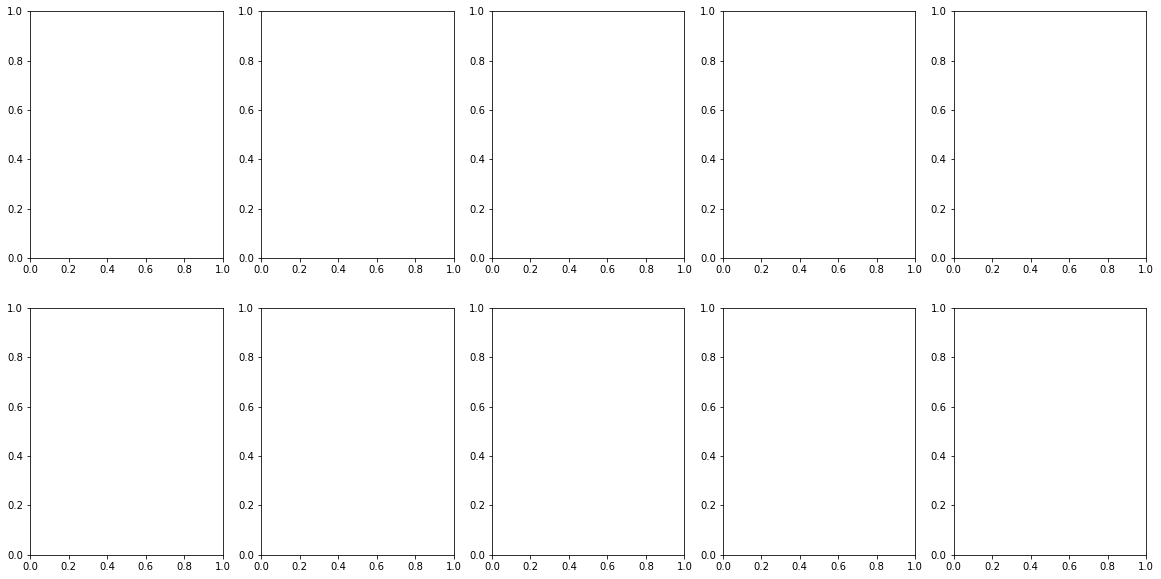

In [35]:
import matplotlib.pyplot as plt
compare_purchases_and_recs(168, rec_ids, rec_scores, idx_to_user, idx_to_article, purchases_dense, all_files)

In [161]:
recs, scores = als.recommend(user_index, train[user_index], N=12, filter_already_liked_items=False)

In [162]:
top_12 = recs[:,:12]

In [163]:
test_scores = []
train_scores = []
for i, user in enumerate(user_index):
    train_true_purchases = train.getrow(user).indices
    test_true_purchases = test.getrow(user).indices
    rec_purchases = top_12[i]
    
    test_score = float(len(set(test_true_purchases) & set(rec_purchases))) / 5.0
    test_scores.append(test_score)
    
    train_score = float(len(set(train_true_purchases) & set(rec_purchases))) / 5.0
    train_scores.append(train_score)

In [164]:
print(np.mean(test_scores))
print(np.mean(train_scores))

0.03312111549478463
0.4960082148840729


Now plotting training ALS with confidence scores

In [53]:
als_conf = implicit.als.AlternatingLeastSquares()
als_conf.fit(purchases_with_confidence)

  0%|          | 0/15 [00:00<?, ?it/s]

In [165]:
rec_ids, rec_scores = als_conf.recommend(user_index, train[user_index], N=12, filter_already_liked_items=False)

In [55]:
top_5_conf = rec_ids[:,:5]

In [166]:
test_scores = []
train_scores = []
for i, user in enumerate(user_index):
    train_true_purchases = train.getrow(user).indices
    test_true_purchases = test.getrow(user).indices
    rec_purchases = rec_ids[i]
    
    test_score = float(len(set(test_true_purchases) & set(rec_purchases))) / 5.0
    test_scores.append(test_score)
    
    train_score = float(len(set(train_true_purchases) & set(rec_purchases))) / 5.0
    train_scores.append(train_score)

In [168]:
print(np.mean(test_scores))
print(np.mean(train_scores))

0.10463168134897044
0.4876938874777064


### Temporal based confidene

In [60]:
als_conf_r = implicit.als.AlternatingLeastSquares()
als_conf_r.fit(purchases_with_confidence_recent)

  0%|          | 0/15 [00:00<?, ?it/s]

In [169]:
rec_ids, rec_scores = als_conf_r.recommend(user_index, train[user_index], N=12, filter_already_liked_items=False)
top_5_conf = rec_ids[:,:5]
test_scores = []
train_scores = []
for i, user in enumerate(user_index):
    train_true_purchases = train.getrow(user).indices
    test_true_purchases = test.getrow(user).indices
    rec_purchases = rec_ids[i]
    
    test_score = float(len(set(test_true_purchases) & set(rec_purchases))) / 5.0
    test_scores.append(test_score)
    
    train_score = float(len(set(train_true_purchases) & set(rec_purchases))) / 5.0
    train_scores.append(train_score)

In [170]:
print(np.mean(test_scores))
print(np.mean(train_scores))

0.10464681403015727
0.4873544830568015


To be rerun with varying train and test sets (i.e. different random samples) and mean and confidence interval to be run for each one

In [298]:
def calc_model_confidence(user_item_sparse, split_count=5, fraction=0.1, n_iter=50):
    
    overall_train_scores = []
    overall_test_scores = []
    
    for i in range(n_iter):
        
        print(f'Running iteration {i}')
        train, test, user_index = train_test_split(user_item_sparse, split_count=split_count, fraction=fraction)
        
        model = implicit.als.AlternatingLeastSquares()
        model.fit(train)
        
        recs, scores = model.recommend(user_index, train[user_index], filter_already_liked_items=False)
        
        top_5_recs = recs[:,:5]
        
        test_scores = []
        train_scores = []
        for i, user in enumerate(user_index):
            train_true_purchases = train.getrow(user).indices
            test_true_purchases = test.getrow(user).indices
            rec_purchases = top_5_recs[i]

            test_score = float(len(set(test_true_purchases) & set(rec_purchases))) / 5.0
            test_scores.append(test_score)

            train_score = float(len(set(train_true_purchases) & set(rec_purchases))) / 5.0
            train_scores.append(train_score)
    
        overall_train_scores.append(np.mean(train_scores))
        overall_test_scores.append(np.mean(test_scores))
        
    return overall_train_scores, overall_test_scores
        
        

In [299]:
train_scores, test_scores = calc_model_confidence(purchases_sparse, n_iter=3)

Running iteration 0


  0%|          | 0/15 [00:00<?, ?it/s]

Running iteration 1


  0%|          | 0/15 [00:00<?, ?it/s]

Running iteration 2


  0%|          | 0/15 [00:00<?, ?it/s]

In [297]:
train_scores, test_scores

([0.346834567367454,
  0.34564124736529217,
  0.34589417932227207,
  0.3471999135275361,
  0.346817272874669,
  0.34571258714803005,
  0.3463481597578771,
  0.34598497540939305,
  0.3442728206236827,
  0.344640328595363,
  0.3465340755553154,
  0.3477209101226828,
  0.3439442252607686,
  0.3461427876560559,
  0.34701399773009783,
  0.34556126033616175,
  0.3451007944657623,
  0.3474247419337405,
  0.34531049019077986,
  0.34544668432146136],
 [0.018146246554612767,
  0.018163541047397723,
  0.017748473220558832,
  0.018074906771874833,
  0.017452305031616495,
  0.017988434307950066,
  0.018360265902826575,
  0.01780251851051181,
  0.0176101172782792,
  0.0178695346700535,
  0.018291087931686753,
  0.017817651191698643,
  0.018040317786304924,
  0.017705236988596443,
  0.01769226611900773,
  0.01785656380046479,
  0.017860887423661032,
  0.017830622061287358,
  0.01763605901745663,
  0.017904123655623414])

Num purchases for user = 1157


/Users/grantbeasley/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


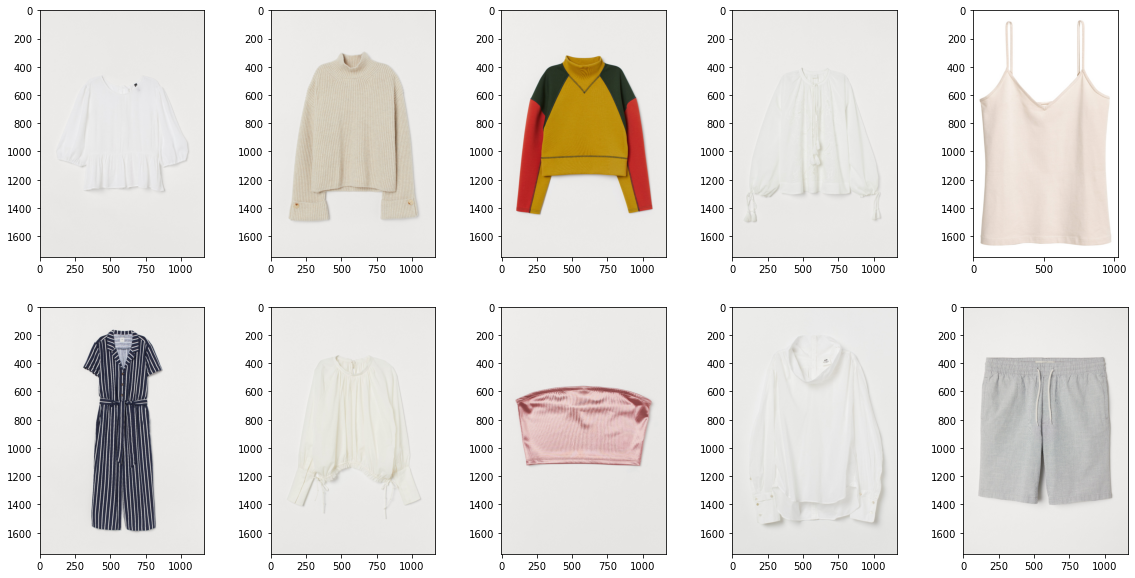

/Users/grantbeasley/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


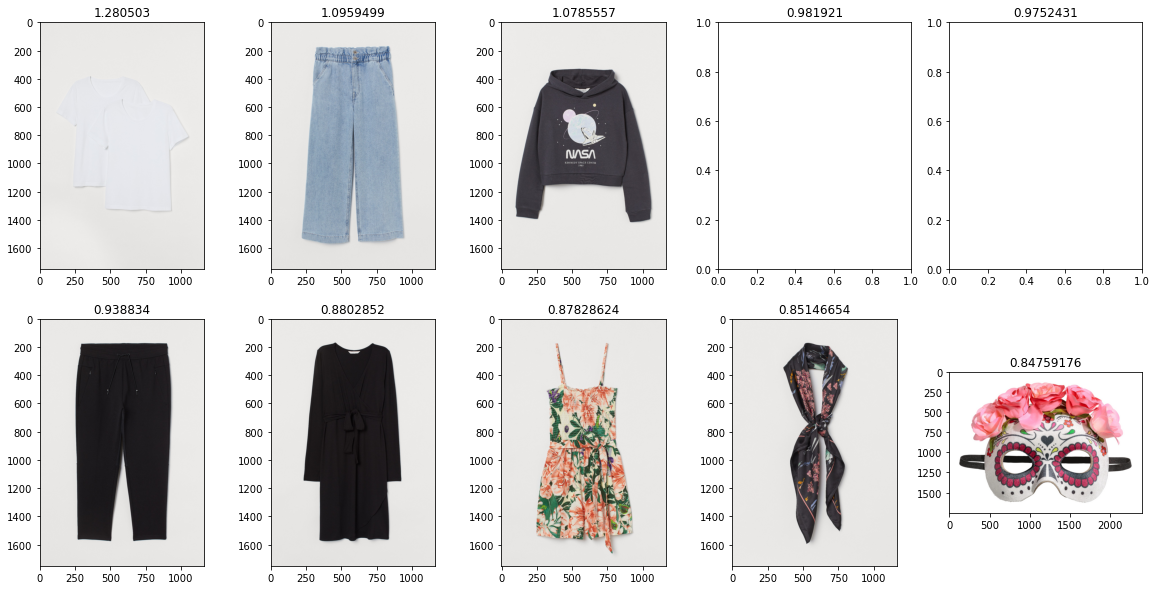

In [116]:
compare_purchases_and_recs(200, rec_ids, rec_scores, idx_to_user, idx_to_article, purchases_dense, all_files)